**Github commit**:
* git checkout branch
* git add filename
* git commit -m "actionname"
* git push origin

Let's start from importing the dummy **dataset** with the columns assumptions:

In [242]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('Dataset_test.csv', low_memory = False)

Then let's create a dataframe containing only line items associated with completed orders. And secondly group the data so that **every row corresponds to an order** placed by a customer.

In [243]:
# Get Orders, exclude Sessions
line_orders = df[~df.Order_id.isnull()]

#Group the data 
orders = df.groupby(['Order_id', 'Merchant', 'Customer_id', 'Datetime', 'Country', 'Shipping Zip']).agg({
    'Blink_shipping': 'sum',
    'Cap_eligibility': 'sum',
    'Inventory_av_eligibility': 'sum',
    'New_to_blink': 'sum',
    'New_to_merch': 'sum',
    'New_to_blink': 'sum',
    'Lineitem_quantity': 'sum',
    'Lineitem_price': 'sum',
    'Shipping_price': 'max'
}).reset_index()

#Add time columns
orders['date'] = pd.to_datetime(orders.Datetime).dt.date
orders['day_of_week'] = pd.to_datetime(orders.Datetime).dt.day_name()
orders['hour_of_day'] = pd.to_datetime(orders.Datetime).dt.hour
orders['month_num'] = pd.to_datetime(orders.Datetime).dt.month

Below you can enter the parameters that you wanna use to filter the dataframe we compute above

In [244]:
#Parameters {for multiple values use a list [item1, item2]}

country_list = ['IT']
merchant_list = ['Ketofood']
date_start = '2021-11-20'
date_end = '2022-11-30'
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday']
hod_start = 12
hod_end = 15

date_start = pd.to_datetime(date_start)
date_end = pd.to_datetime(date_end)

If you don't wanna use specific filters, just **comment** the line of code (below) where that filter is. You can do that by using '#'.

In [245]:
orders_filtered = orders[
    orders.Country.isin(country_list) 
    & orders.Merchant.isin(merchant_list) 
    & (orders.date >= date_start) 
    & (orders.date < date_end) 
    & (orders.day_of_week.isin(day_of_week_list))
    & (orders.hour_of_day >= hod_start) 
    & (orders.hour_of_day < hod_end)
    ].reset_index(drop = True)

display(orders.head(5))

C:\Users\Giuseppe\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,Order_id,Merchant,Customer_id,Datetime,Country,Shipping Zip,Blink_shipping,Cap_eligibility,Inventory_av_eligibility,New_to_blink,New_to_merch,Lineitem_quantity,Lineitem_price,Shipping_price,date,day_of_week,hour_of_day,month_num
0,#11946,Ketofood,robbygp@libero.it,2021-11-15 13:13:59 +0100,IT,20851,0.0,1.0,1.0,0.0,1.0,2,8.99,2.99,2021-11-15,Monday,13,11
1,#11947,Ketofood,meryalfano969@gmail.com,2021-11-15 14:15:11 +0100,IT,90136,0.0,1.0,0.0,0.0,0.0,2,8.99,2.99,2021-11-15,Monday,14,11
2,#11948,Ketofood,rudi.vittori@gmail.com,2021-11-15 16:07:40 +0100,IT,34076,0.0,1.0,1.0,1.0,0.0,1,23.95,2.99,2021-11-15,Monday,16,11
3,#11949,Ketofood,sterob.dental@tiscali.it,2021-11-15 16:43:09 +0100,IT,10143,0.0,0.0,1.0,0.0,0.0,1,14.95,0.00,2021-11-15,Monday,16,11
4,#11950,Ketofood,anninacamel@gmail.com,2021-11-15 18:37:50 +0100,IT,41043,0.0,1.0,0.0,0.0,0.0,1,9.99,2.99,2021-11-15,Monday,18,11


## From here we can compute the **KPIs**:

**1. Percentage of serviceable orders** 
<p> <i>Description</i>: number of orders where Blink is shown at checkout divided by the total number of orders </p>

,Cap_eligibility,Inventory_av_eligibility,Order_id,Percent
0,0.0,0.0,83,0.216710
1,0.0,1.0,89,0.232376
2,1.0,0.0,120,0.313316
3,1.0,1.0,91,0.237598


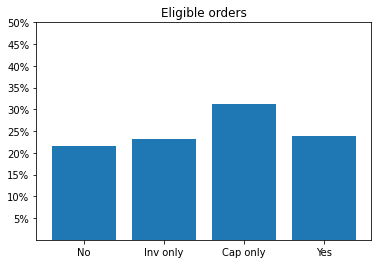

In [246]:
perc_serv_ord = orders_filtered.groupby(['Cap_eligibility', 'Inventory_av_eligibility']).Order_id.count().reset_index()
perc_serv_ord['Percent'] = perc_serv_ord.Order_id / perc_serv_ord.Order_id.sum()

display(perc_serv_ord)

ax = plt.subplot()
plt.bar(range(len(perc_serv_ord.Cap_eligibility)), perc_serv_ord.Percent)
ax.set_xticks(range(len(perc_serv_ord)))
ax.set_xticklabels(['No', 'Inv only', 'Cap only', 'Yes'])
ax.set_yticks([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50])
ax.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%', '45%', '50%'])
plt.title('Eligible orders')
plt.show()

**2. Percentage of turnover through Blink orders** 
<p> <i>Description</i>: revenue from Blink orders divided by the total revenue </p>

,Blink_shipping,Lineitem_price,Percent
0,0.0,6999.81,0.98359
1,1.0,116.78,0.01641


(-1.105592837197417,
 1.1002663287412988,
 -1.1074879403090896,
 1.1034956899213935)

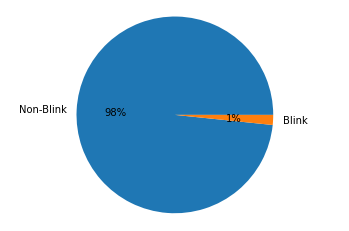

In [247]:
perc_rev = orders_filtered.groupby(['Blink_shipping']).Lineitem_price.sum().reset_index()
perc_rev['Percent'] = perc_rev.Lineitem_price / perc_rev.Lineitem_price.sum()

display(perc_rev)

plt.figure()
plt.pie(perc_rev.Lineitem_price, labels = ['Non-Blink', 'Blink'], autopct = '%d%%')
plt.axis('equal')

**3. Purchasing Frequecy ratio** 
<p> <i>Description</i>: Orders/month of customer that made more 3 orders from one merchant with Blink vs without Blink. </p>

In [241]:
customer_table = orders_filtered.groupby(['Customer_id', 'month_num', 'Blink_shipping']).Order_id.count()

display(customer_table)

Customer_id                            month_num  Blink_shipping
Bigmenny81@yahoo.it                    2          0.0               1
Claudia.massucco@libero.it             1          0.0               1
Franca0564@gmail.com                   12         0.0               1
Krisiu@libero.it                       12         0.0               1
Luigi.salerno@virgilio.it              1          0.0               1
                                                                   ..
vruggeri77@libero.it                   1          0.0               1
yuliandrea.garciaorozco86@hotmail.com  1          0.0               1
zarattiniantonella@libero.it           12         0.0               1
zennaro.ilaria@virgilio.it             1          0.0               1
zoilinda@gmail.com                     11         0.0               1
Name: Order_id, Length: 376, dtype: int64